In [1]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

sys.path.append("code/preprocessing/utils/")
from segment2D     import *
from segment3D     import *
from file_handling import *

sys.path.append("code/analysis/utils/")

from data_class import SegmentationData, VariationData, AutocorrelationData
from variation_functions import spatial_variation, global_density

pix_to_um = get_pixel_size()

In [ ]:
dataset = "holomonitor_20240103_A2-1"

#config  = json.load(open(f"data/experimental/configs/{dataset}.json"))
#microscope = Path(dataset).stem.split("_")[0]

In [6]:
# load data

#h_stack = import_stack(f"data/experimental/raw/{dataset}/", config)

cellprop = SegmentationData(f"data/experimental/processed/{dataset}/cell_props.p")

# cellcorr  = AutocorrelationData(f"data/experimental/processed/{dataset}/cell_autocorr.p")

fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")
# df     = pd.read_csv(f"data/experimental/processed/{dataset}/dataframe_unfiltered.csv")

# print("cell:",  cellcorr.log)
#print("field:", fieldcorr.log)

In [7]:
N = len(fieldcorr.density)
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))


for i in range(N):
    plt.plot(fieldcorr.r_array['hh'] / 12, fieldcorr.spatial['hh'][i], c=colors[i])

In [8]:
plt.show()

159
State loaded from data/experimental/processed/holomonitor_20240516_A2-7/field_autocorr.p.
State loaded from data/experimental/processed/holomonitor_20240516_A2-1/field_autocorr.p.


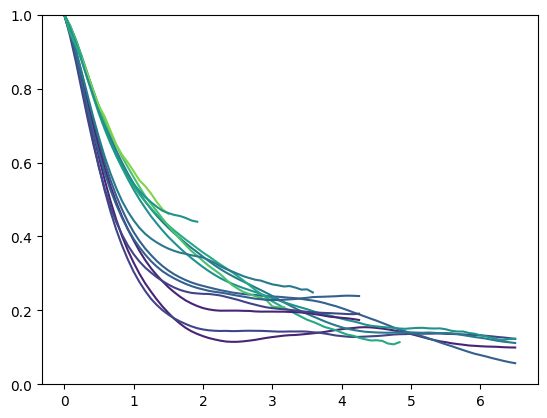

In [135]:
# densities = np.arange(1400, 3200)
# N = len(densities)
N = 159
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))

print(N)

dataset = "holomonitor_20240516_A2-7"
fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")

#plt.subplot(121)
plt.ylim(0,1)
for i in range(0, len(fieldcorr.temporal['hh']), 20):
    j = int(fieldcorr.density[i]) - 1400
    plt.plot(fieldcorr.t_array['hh'] / 12, np.mean(fieldcorr.temporal['hh'][i:i+20], axis=0), c=colors[i])


dataset = "holomonitor_20240516_A2-1"
fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")

#plt.subplot(122)
plt.ylim(0,1)
for i in range(0, len(fieldcorr.temporal['hh']), 20):
    j = int(fieldcorr.density[i]) - 1400
    plt.plot(fieldcorr.t_array['hh'] / 12, np.mean(fieldcorr.temporal['hh'][i:i+20], axis=0), c=colors[i])

1800
State loaded from data/experimental/processed/holomonitor_20240516_A2-7/field_autocorr.p.
State loaded from data/experimental/processed/holomonitor_20240516_A2-1/field_autocorr.p.


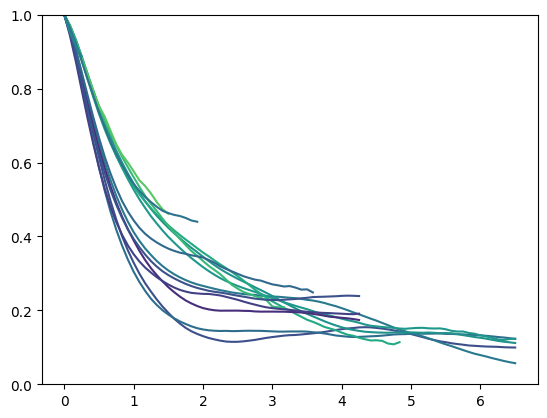

In [147]:
densities = np.arange(1400, 3200)
N = len(densities)
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))

print(N)

dataset = "holomonitor_20240516_A2-7"
fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")

#plt.subplot(121)
plt.ylim(0,1)
for i in range(0, len(fieldcorr.temporal['hh']), 20):
    j = int(fieldcorr.density[i]) - 1400
    plt.plot(fieldcorr.t_array['hh'] / 12, np.mean(fieldcorr.temporal['hh'][i:i+20], axis=0), c=colors[j])


dataset = "holomonitor_20240516_A2-1"
fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")

#plt.subplot(122)
plt.ylim(0,1)
for i in range(0, len(fieldcorr.temporal['hh']), 20):
    j = int(fieldcorr.density[i]) - 1400
    plt.plot(fieldcorr.t_array['hh'] / 12, np.mean(fieldcorr.temporal['hh'][i:i+20], axis=0), c=colors[j])

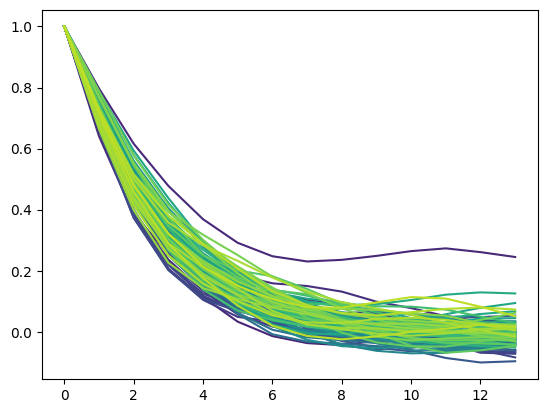

In [146]:
densities = np.arange(1400, 3200)
N = 100
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))
for i in range(100):
    plt.plot(fieldcorr.spatial['vv'][i], c=colors[i])

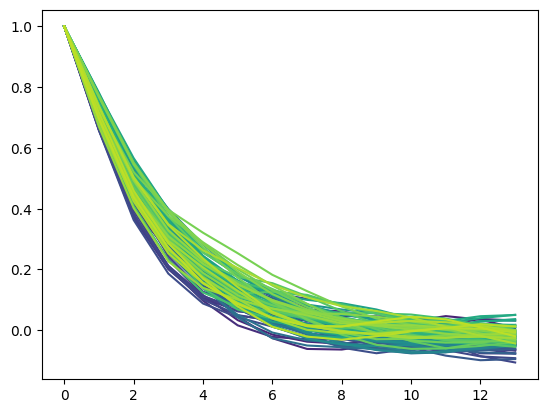

In [148]:
densities = np.arange(1400, 3200)
N = 100
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))
for i in range(100):
    plt.plot(fieldcorr.spatial['vv'][i], c=colors[i])

In [9]:
density = np.unique(np.concatenate([Cr_binned_A2_1['density_bins'], Cr_binned_A2_7['density_bins']]))
N = len(density)
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))

density, Cr_binned_A2_1['density_bins'], Cr_binned_A2_7['density_bins']

(array([1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]),
 array([1400, 1600, 1800, 2000, 2200]),
 array([1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]))

In [11]:
for i in range(1, len(density)-1):
    ax[1].plot(r_A2_7, Cr_binned_A2_7['mean'][i-1], c=colors[i])

for i in range(0, len(Cr_binned_A2_1['mean'])):
    ax[1].plot(r_A2_1, Cr_binned_A2_1['mean'][i], c=colors[i])


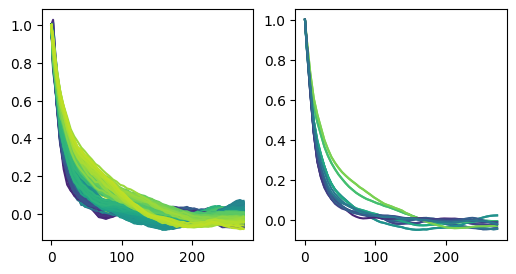

In [12]:
fig

In [13]:
binned_corr = [Cr_binned_A2_1, Cr_binned_A2_7]
r_array = np.unique(np.concatenate([r_A2_1, r_A2_7]))
        

# Sort by density
bins  = np.unique(np.concatenate([binned['density_bins'] for binned in binned_corr]))
means = np.zeros([len(binned_corr), len(bins)-1, len(r_array)])
stds  = np.zeros([len(binned_corr), len(bins)-1, len(r_array)])
print(np.shape(means))

i = 0
for corr in binned_corr:
    density_idx = np.digitize(corr['density_bins'], bins)

    means[i, density_idx[:-1]-1] = corr['mean']
    stds[i, density_idx[:-1]-1]  = corr['std']

    i += 1


(2, 8, 56)


In [14]:
np.shape(means), bins

((2, 8, 56), array([1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]))

In [32]:
def weighted_average(data, err, ax):

    # Take weighted average
    mask = (data==0)
    data = np.ma.array(data, mask=mask)
    err  = np.ma.array(err,  mask=mask)

    weights = 1 / err.data**2
    weights[err==0] = 1
    weights = np.ma.array(weights, mask=mask)
    N = np.sum(weights!=0, axis=ax)

    wmean = np.ma.average(data,            weights=weights, axis=ax)
    wstd  = np.ma.average((data-wmean)**2, weights=weights, axis=ax) * N / (N-1)

    return wmean, wstd

In [34]:
wmean, wstd = weighted_average(means, stds, ax=0)

/tmp/ipykernel_4980/3404068586.py:8: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / err.data**2


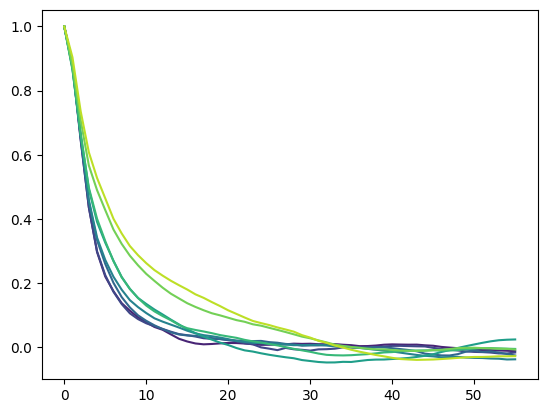

In [35]:
N = 8
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, N))

for i in range(len(wmean)):
    plt.plot(wmean[i], c=colors[i])

In [52]:
mean_corr = np.zeros([len(bins)-1, len(fieldcorr.spatial['hh'][0])])
std_corr  = np.zeros([len(bins)-1, len(fieldcorr.spatial['hh'][0])])
counts    = np.zeros(len(bins)-1)

density_idx = np.digitize(fieldcorr.density, bins)

In [53]:
for i in range(1, len(bins)):
    idx_in_bin = np.where(density_idx == i)[0]
    counts[i-1] = len(idx_in_bin)

    if counts[i-1] == 0:
        #mean_corr[i-1] = np.nan
        #std_corr[i-1]  = np.nan
        continue

    mean_corr[i-1] = np.mean(fieldcorr.spatial['hh'][idx_in_bin], axis=0)
    if counts[i-1] > 1:
        std_corr[i-1]  = np.std(fieldcorr.spatial['hh'][idx_in_bin], axis=0, ddof=1)

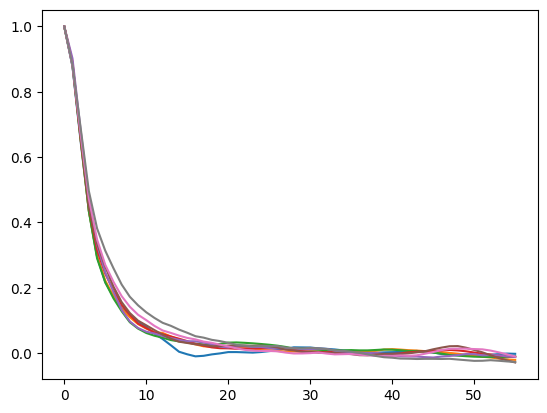

In [54]:
for co in mean_corr:
    plt.plot(co)

In [47]:
np.shape(fieldcorr.spatial['hh']), len(fieldcorr.spatial['hh'])

((104, 56), 104)

In [ ]:

for i in range(10):
    plt.plot(fieldcorr.r_array['hh'], fieldcorr.spatial['hh'][i])

# plt.plot(np.mean(cellcorr.spatial['vv'], axis=0))

In [ ]:
def hexagon_side(V0):
    """ Computes side length of regular hexagon from volume """

    return ((2 / 3**2) * V0) ** (1/3)

V0 = np.mean(cellprop.A * cellprop.h)
r6 = hexagon_side(V0)

np.float64(7.581684038029669)

[Text(0.5, 0, '$r~/~r_6^*$')]

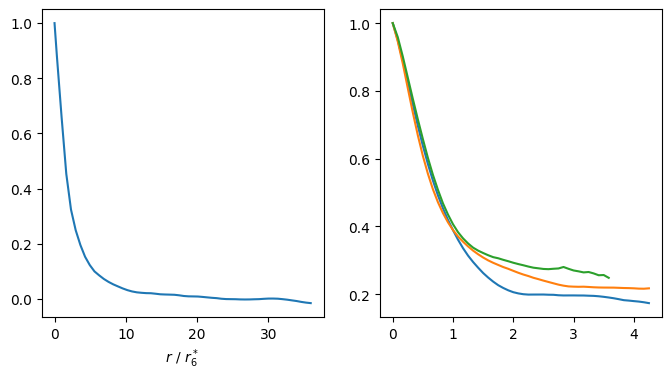

In [123]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(fieldcorr.r_array["hh"] / r6, np.ma.mean(fieldcorr.spatial["hh"], axis=0), label="exp")

ax[1].plot(fieldcorr.t_array["hh"] / 12, np.ma.mean(fieldcorr.temporal["hh"][:20], axis=0))
ax[1].plot(fieldcorr.t_array["hh"] / 12, np.ma.mean(fieldcorr.temporal["hh"][30:50], axis=0))
ax[1].plot(fieldcorr.t_array["hh"] / 12, np.ma.mean(fieldcorr.temporal["hh"][60:70], axis=0))

ax[0].set(xlabel=r"$r~/~r_6^*$")

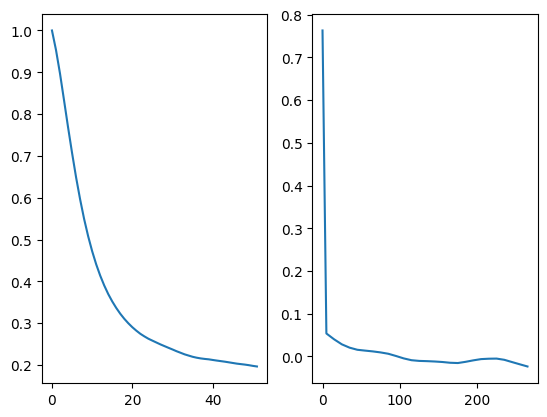

In [85]:

plt.subplot(121)
plt.plot(fieldcorr.t_array['hh'], np.mean(fieldcorr.temporal['hh'], axis=0), '-')

plt.subplot(122)
plt.plot(fieldcorr.r_array['hh'], np.mean(fieldcorr.spatial['hh'], axis=0), '-')
